In [ ]:
import os
exists = os.path.isfile('readtria.py')
if not(exists):
    print("Downloading meshes ...")
    !git clone https://github.com/dpeschka/NumFluids.git
    !cp -r NumFluids/notebook/meshes .
    !cp NumFluids/notebook/readtria.py .
else:
    print("All is set.")

# General functions for all examples

These functions extend the code of the previous lecture in the following sense:

* more flexible tensor mesh
* local stiffness matrix with space-dependent coefficient $a(x)$
* local mass matrix with space-dependent coefficient $c(x)$
* convection matrix with space-dependent vector $\vec{u}(x)$
* output into vtk files for visualization in paraview (see `readtria.py`)

The corresponding functions are streamlined a little bit, i.e. `np.matmul` is used consistently.

Hint: Via `readtria` you can read the following meshes from `./meshes`

* `disc1`,`disc2`,`disc3`,`disc4` which are increasingly fine version of $\{(x,y)\in\mathbb{R^2}:x^2+y^2\le 1\}$.
* `haus` a supercoarse test mesh constructed by hand
* `house.1` a nice mesh resembling a 2D house
* `box` a unit disc (better use `tensor_mesh` or `square_mesh`)
* `mesh1` a coarse annulus
* `mesh2` a coarse disc
* `mesh3` a coarse square
* `cheese` a domain with smooth boundary and some holes
* `domain_disc` currently incompatible


In [2]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve,splu
from scipy.spatial import Delaunay

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from readtria import readtria, writevtk

def square_mesh(L=1.0,k=16):
    h = L/k
    xh, yh = np.meshgrid(np.linspace(0,L,k), np.linspace(0,L,k)) 
    xh     = xh.flatten()
    yh     = yh.flatten()
    points = np.array([xh,yh]).T
    tri    = Delaunay(points)
    e2     = tri.simplices
    
    nelement = np.size(e2,0)
    npoint   = np.size(xh,0)
    
    idp      = np.zeros(npoint)
    idp[(xh<h/2)|(yh<h/2)|(xh>(L-h/2))|(yh>(L-h/2))] = 1
    ide      = []
    return xh,yh,npoint,nelement,e2,idp,ide

def tensor_mesh(Lx,Ly):
    eeps = 1e-8
    x0 = Lx[ 0]+eeps
    x1 = Lx[-1]-eeps
    y0 = Ly[ 0]+eeps
    y1 = Ly[-1]-eeps
    xh, yh = np.meshgrid(Lx,Ly) 
    xh     = xh.flatten()
    yh     = yh.flatten()
    points = np.array([xh,yh]).T
    tri    = Delaunay(points)
    e2     = tri.simplices
    
    nelement = np.size(e2,0)
    npoint   = np.size(xh,0)
    
    idp      = np.zeros(npoint)
    idp[(xh<x0)|(yh<y0)|(xh>x1)|(yh>y1)] = 1
    ide      = []
    return xh,yh,npoint,nelement,e2,idp,ide

def generate_transformation2D(k, e2, x, y):
    dx1 = x[e2[k, 1]]-x[e2[k, 0]]
    dy1 = y[e2[k, 1]]-y[e2[k, 0]]

    dx2 = x[e2[k, 2]]-x[e2[k, 0]]
    dy2 = y[e2[k, 2]]-y[e2[k, 0]]

    # determinant on each triangle
    Fdet = dx1*dy2 - dx2*dy1

    # transformation Jacobian on each triangle
    Finv = np.zeros((2, 2))
    Finv[0, 0] =  dy2 / Fdet
    Finv[0, 1] = -dx2 / Fdet
    Finv[1, 0] = -dy1 / Fdet
    Finv[1, 1] =  dx1 / Fdet

    return Fdet, Finv

# computes the local stiffness matrix in 2D, i.e. int grad(w_i)*grad(w_j) dx
# by transformation to reference, where the shape functions phi are used
def local_stiff2D(a,Fdet, Finv):
    gradphi = np.array([[-1, -1], [1, 0], [0, 1]]).T
    dphi    = np.matmul(Finv.T,gradphi)
    S = a/2*np.matmul(dphi.T,dphi)*Fdet
    return S

# computes the local convection matrix in 2D, i.e. int w_i u*grad(w_j) dx
def local_conv2D(uvec,Fdet, Finv):
    locmass = np.array([[1, 1/2, 1/2], [1/2, 1, 1/2], [1/2, 1/2, 1]])/12.0
    gradphi = np.array([[-1, -1], [1, 0], [0, 1]]).T
    dphi    = np.matmul(Finv.T,gradphi)
    C = np.matmul(np.matmul(locmass,uvec),dphi)*Fdet
    return C

# computes the local mass matrix in 2D, i.e. int w_i w_j dx
def local_mass2D(c,Fdet):
    return c*Fdet*np.array([[1, 1/2, 1/2], [1/2, 1, 1/2], [1/2, 1/2, 1]])/12

# Lecture 06

In this part we want to lay the foundation to apply all the techniques introduced before to fluid flows. This means that we need to be able to

- Solve constraints.
- Solve (vectorial) systems of equations.
- Understand incompressibility.

Therefore think about the following tasks:

1. Reformulate the code above to solve

$$
-\nabla \cdot (a \nabla \vec{u}) + c \vec{u} = \vec{f}
$$

for given functions $a,c:\Omega\to\mathbb{R}$ and $\vec{f}:\Omega\to\mathbb{R}^d$.

2. Check out the Chorin projection, as it is introduced in the video lectures, i.e. an arbitrary vector field $\vec{u}$ is decomposed

$$
\vec{u} = \vec{u}_{ir} + \vec{u}_0
$$

where the irrotational part obeys $\vec{u}_{ir}=\nabla\phi$ and the remainder is divergence-free $\nabla\cdot\vec{u}_0=0$. This implies

$$
\nabla\cdot \vec{u} = \nabla\cdot(\nabla\phi)
$$

which we can solve using the weak formulation introduced above. This requires using the stiffness matrix (for the Laplace operator) and the convection matrix (to compute the divergence of $\vec{u}$) in the problem formulation. First, one computes $\phi$ via

$$
\int_\Omega \nabla\phi\cdot\nabla v\,\mathrm{d}x = \int_\Omega (-\nabla\cdot\vec{u})v\,\mathrm{d}x.
$$


The mass matrix is required in order to compute the gradient of $\phi$, i.e. we compute $\vec{w}=\nabla\phi$ via

$$
\int \vec{w}\cdot \vec{v}\,\mathrm{d}x=\int_\Omega \vec{v}\cdot\nabla\phi\,\mathrm{d}x,
$$

where on the left side we require a vectorial mass matrix and on the right side the convection matrix.

Below an example, where the divergence of a given vector field is computed.

read mesh file: ./meshes/disc2
L2 divu= 0.07548011634736357


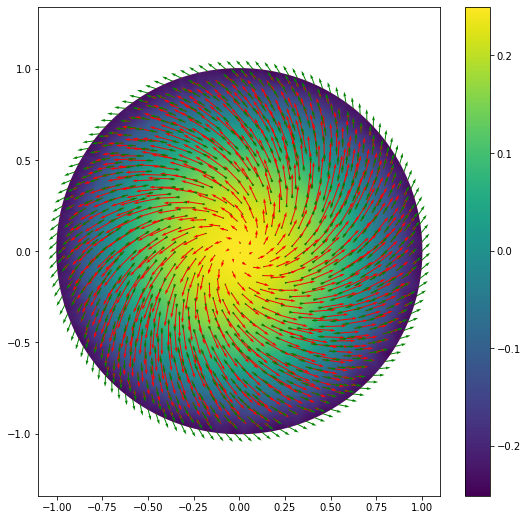

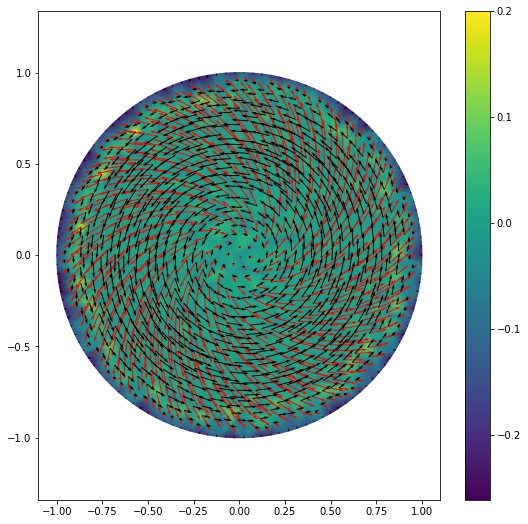

In [5]:
# FEM Python sample code
Lx = np.linspace(-1,1,32)
Ly = np.linspace(-1,1,32)
# x,y,npoint,nelement,e2,idp,ide = tensor_mesh(Lx,Ly)
x,y,npoint,nelement,e2,idp,ide = readtria('./meshes/disc2')  # read mesh from file
dofmap = e2

# select points without Dirichlet bc
it = np.logical_not(idp == 1)
nphi = 3

# build matrices
ii = np.zeros((nelement, nphi**2))  # sparse i-index
jj = np.zeros((nelement, nphi**2))  # sparse j-index
aa = np.zeros((nelement, nphi**2))  # entry of Galerkin matrix
bb = np.zeros((nelement, nphi**2))  # entry in mass-matrix (to build rhs)
cx = np.zeros((nelement, nphi**2))  # entry in mass-matrix (to build rhs)
cy = np.zeros((nelement, nphi**2))  # entry in mass-matrix (to build rhs)

for k in range(nelement):
    Fdet, Finv = generate_transformation2D(k, e2, x, y)  # compute trafo
    
    # build local matrices (mass, stiffness, ...)
    a  = lambda x,y:  1.0  + 0*x.T
    c  = lambda x,y:  1.0  + 0*x.T
    ex = lambda x,y: np.array((1+0*x,0*x)).T
    ey = lambda x,y: np.array((0*x,1+0*x)).T
    
    # center points (xm,ym) and nodal points (xe,ye) of element
    xe   = x[e2[k,:]]
    ye   = y[e2[k,:]]
    xm   = np.mean(xe)
    ym   = np.mean(ye)
    
    sloc  = local_stiff2D(a(xm,ym),Fdet,Finv ) # element stiffness matrix
    mloc  = local_mass2D (c(xm,ym),Fdet      ) # element mass matrix
    clocx = local_conv2D (ex(xe,ye),Fdet,Finv) # element convection matrix
    clocy = local_conv2D (ey(xe,ye),Fdet,Finv) # element convection matrix
    
    # compute i,j indices of the global matrix
    dofs     = dofmap[k,:]
    ii[k, :] = dofs[[0,0,0,1,1,1,2,2,2]]  # local-to-global
    jj[k, :] = dofs[[0,1,2,0,1,2,0,1,2]]  # local-to-global
    
    # compute a(i,j) values of the global matrix
    aloc = sloc # + cloc
    aa[k, :] = aloc.flatten()
    bb[k, :] = mloc.flatten()
    cx[k, :] = clocx.flatten()
    cy[k, :] = clocy.flatten()

# create sparse matrices
L  = sparse.csc_matrix((aa.flatten(),(ii.flatten(),jj.flatten())),shape=(npoint,npoint))
M  = sparse.csc_matrix((bb.flatten(),(ii.flatten(),jj.flatten())),shape=(npoint,npoint))
Dx = sparse.csc_matrix((cx.flatten(),(ii.flatten(),jj.flatten())),shape=(npoint,npoint))
Dy = sparse.csc_matrix((cy.flatten(),(ii.flatten(),jj.flatten())),shape=(npoint,npoint))

# create sparse matrices
L = sparse.csc_matrix((aa.flatten(),(ii.flatten(),jj.flatten())),shape=(npoint,npoint))
M = sparse.csc_matrix((bb.flatten(),(ii.flatten(),jj.flatten())),shape=(npoint,npoint))

B    = np.reshape(M*(1+0*x),[np.size(x),1])
BT   = np.reshape(M*(1+0*x),[1,np.size(x)])

# Lext = sparse.bmat([[L,B],[BT,0]],format='csc')
# Div  = sparse.bmat([[Dx,Dy]],format='csc')

Lext = sparse.bmat([[L,B],[BT,0]],format='csc')
A    = sparse.bmat([[L,None],[None,L]],format='csc')

id2d = np.append(it,it)

u = np.append(0*x,0*x)

A1 = A[:,id2d]
A2 = A1[id2d,:]

fx = x-y
fy = y+x

rhs = np.append(M*fx,M*fy)

u[id2d] = spsolve(A2,rhs[id2d])

ux = u[:npoint]
uy = u[npoint:(2*npoint)]

phi   = spsolve(Lext,np.append(-Dx*ux-Dy*uy,0))
dpdx  = spsolve(M,Dx*phi[:-1])
dpdy  = spsolve(M,Dy*phi[:-1])

uxn   = ux - dpdx
uyn   = uy - dpdy

divu  = spsolve(M,Dx*ux  + Dy*uy )
divun = spsolve(M,Dx*uxn + Dy*uyn)

plt.figure(figsize=(9,9))
c = plt.tripcolor(x,y,divu,triangles=e2,shading='gouraud')
plt.quiver(x,y,ux ,uy ,color='r',scale=1)
plt.quiver(x,y,fx ,fy ,color='g',scale=50)

plt.axis('equal')
plt.colorbar(c)

plt.figure(figsize=(9,9))
# c = plt.tripcolor(x,y,phi[:-1],triangles=e2,shading='gouraud')
c = plt.tripcolor(x,y,divun,triangles=e2,shading='gouraud')

print("L2 divu=",np.sqrt(np.dot(divun,M*divun)))

# plt.triplot(x,y,triangles=e2,linewidth=0.5)
plt.quiver(x,y,ux ,uy ,color='r',scale=1)
plt.quiver(x,y,uxn,uyn,color='k',scale=1)
plt.axis('equal')
plt.colorbar(c)

